# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

see link to [forcing description](https://github.com/slgentil/croco/blob/master/configs/itbalt/readme.ipynb)

Diagnostics to store:

- surface: 
    - time and x averaged KE(y)
    - time and x averaged relative enstrophy (y)
    - time averaged horizontal wavenumber spectra

- with depth information:
    - time and x averaged KE(z, y)
    - time and x averaged relative enstrophy (z, y)

- time series of x and y averaged modal KE

In [1]:
from glob import glob
import itertools

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.53:45292 Dashboard: http://10.148.1.53:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## diagnostic flags and runs

In [3]:
# flags
flags = {'surface': True, 'spectra': True, 'depth': True, 'vmodes': True}
overwrite=True

root_path = '/home/c11-data/Test_aponte/fsturb/'

#runs = []
#runs.append('fsturb_m0_4km_0a1000j/')
#runs.append('fsturb_m1_4km_0a1000j/')
#runs = runs+['fsturb_m0_a{}_4km_0a1000j/'.format(a) for a in range(4)]

#m, a = 0, '5m2'
#run = 'fsturb_m{}_a'.format(m)+a+'_4km_0a1000j/'

m = 0
a = 1
run = 'fsturb_m{}_a{}_4km_0a300j'.format(m,a)

# tmp
tdir_max = 2

['fsturb_m0_4km_0a1000j/', 'fsturb_m1_4km_0a1000j/']

## Load data

In [4]:
r = pp.Run(root_path+run, outputs=['surf', 'his'], 
           grid_periodicity=True, tdir_max=tdir_max,
           verbose=1)

r['surf'] = r['surf'].rename({'time_instant': 'time'})
r['his'] = r['his'].rename({'time_counter': 'time'})

In [5]:
# utils
def get_vorticity(u, v, r):
    xi = ((-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))
            .rename('vorticity')
           )
    return xi

---

## vertical modes

In [8]:
nmodes = 10

# compute vertical modes from output stratification
ds_depth = r.load_diagnostic('depth')
ds_depth = ds_depth.mean(['y_rho','y_v'])
vmodes = vmd.Vmodes(r['xgrid'],
                    ds_depth.z_rho, ds_depth.z_w,
                    ds_depth.N2,
                    nmodes,
                    persist=True)
r.store_vmodes('vmodes', vmodes, mode='w')
#vmodes = r.load_vmodes(vmodes_name, persist=True)

# project
ds = r['his']
#ds = r['his'].isel(time=slice(0,2))
#ds = r['his'].isel(time=[0])

Nck = 100
chunks = {'x_rho': Nck, 'y_rho': Nck}
chunks_u = {'x_u': Nck, 'y_rho': Nck}
chunks_v = {'x_rho': Nck, 'y_v': Nck}

u = ds['u_t_dirac'].chunk(chunks_u).rename('u') 
v = ds['v_t_dirac'].chunk(chunks_v).rename('v')
xi = r.x2rho(get_vorticity(u, v, r)).chunk(chunks)

ssh = ds['ssh_t_dirac'].rename('ssh') 
z_r = r.get_z(zeta=ssh).chunk(chunks)
# passing z_u and z_v would not work with horizontally varying modes
z_u = r.get_z(zeta=ssh, hgrid='u').chunk(chunks_u)
z_v = r.get_z(zeta=ssh, hgrid='v').chunk(chunks_v)
z_w = r.get_z(zeta=ssh, vgrid='w').chunk(chunks)

un = vmodes.project(u, "p", z=z_u).rename('un')
#r.store_diagnostic('vmodes_un', un, overwrite=overwrite)

vn = vmodes.project(v, "p", z=z_v).rename('vn')
#r.store_diagnostic('vmodes_vn', vn, overwrite=overwrite)

Store vertical modes in /home/c11-data/Test_aponte/fsturb/fsturb_m0_4km_0a1000j/diagnostics/vmodes.zarr


### pressure projection does not look right, maybe

In [9]:
# compute pressure on rho grid
rho = ds['T_t_dirac'].rename('rho')
p = r.get_p(rho, z_w, zr=z_r)
p0 = p

# interpolates on mode vertical grid
p = gop.interp2z(vmodes['z_rho'], z_r, p)
p1 = p

# substract time and spatial average
p = p - ds_depth['p'] 

# project, data is already on vmode vertical grid
pn = vmodes.project(p, 'p')
# abs(ds_depth['z_rho'] - vmodes['z_rho']).max().compute() # 0

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 24
  **blockwise_kwargs,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 24
  **blockwise_kwargs,
/home1/datahome/aponte/croco/crocosi/gridop.py:533: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)


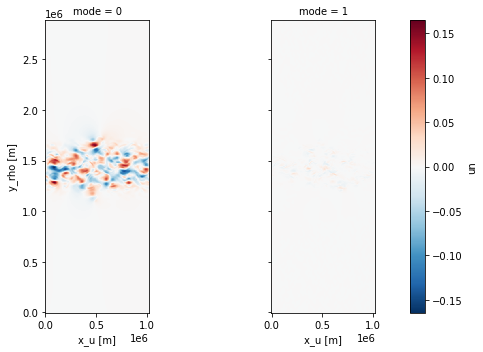

In [16]:
it=4
kwargs_plt = {'col': 'mode', 'figsize': (10,5), 
              'aspect': .5, 'subplot_kws': {'aspect':'equal'}
             }
un.isel(time=it, mode=[0,1]).plot(**kwargs_plt)

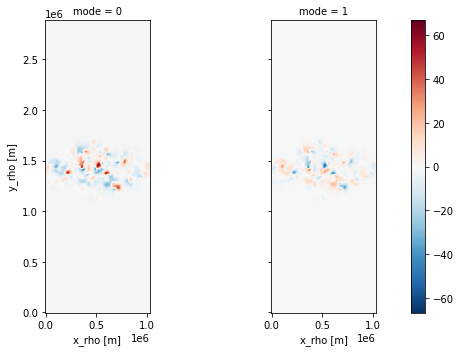

In [17]:
pn.isel(time=it, mode=[0,1]).plot(**kwargs_plt)

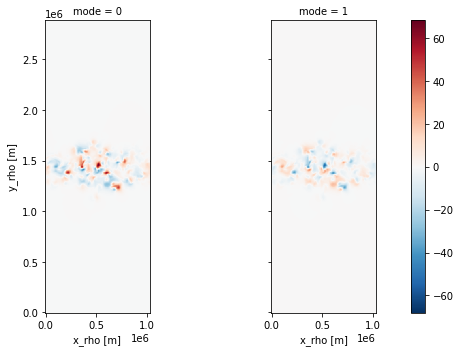

In [18]:
_p = pn.isel(time=it, mode=[0,1])
(_p-_p.mean(['x_rho','y_rho'])).plot(**kwargs_plt)

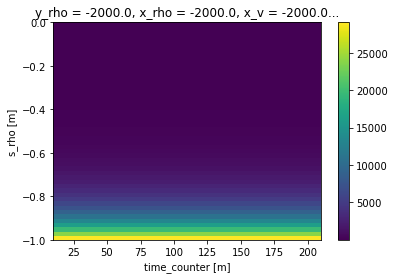

In [19]:
p1.isel(x_rho=0, y_rho=0).plot(x='time')

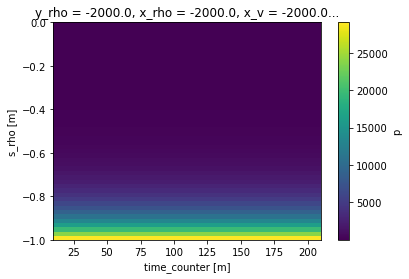

In [20]:
p0.isel(x_rho=0, y_rho=0).plot(x='time')

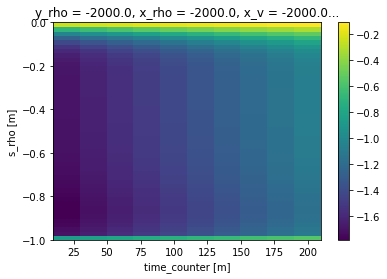

In [21]:
p.isel(x_rho=0, y_rho=0).plot(x='time')

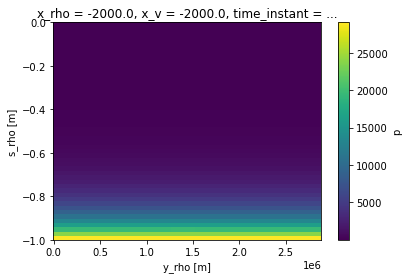

In [22]:
p0.isel(time=it, x_rho=0).plot()

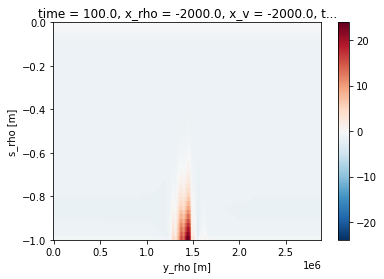

In [26]:
p.isel(time=it, x_rho=0).plot(x='y_rho')

In [24]:
pn.isel(time=it, mode=0).std().compute()

<xarray.DataArray ()>
array(3.69885017)
Coordinates:
    time          float64 100.0
    time_instant  float64 100.0
    mode          int64 0

In [25]:
pn.isel(time=it, mode=1).std().compute()

<xarray.DataArray ()>
array(2.70526879)
Coordinates:
    time          float64 100.0
    time_instant  float64 100.0
    mode          int64 1

In [ ]:
# store vmodes statistics
# ...

---

In [27]:
cluster.close()